In [ ]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix
import networkx as nx

In [ ]:
breast_cancer = pd.read_csv(
    'assets/Breast Cancer Wisconsin.csv',
    sep=',',
    header=0
)
breast_cancer.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [ ]:
breast_cancer.drop(
    ['id', 'Unnamed: 32'] ,axis=1, inplace=True
)
len(breast_cancer)

569

In [ ]:
values_len = len(breast_cancer)
values = breast_cancer.diagnosis.unique()
counts = breast_cancer.diagnosis.value_counts()

print(f'{values[0]}: {counts[0]} | {counts[0] / values_len * 100:3f}%')
print(f'{values[1]}: {counts[1]} | {counts[1] / values_len * 100:3f}%')

M: 357 | 62.741652%
B: 212 | 37.258348%


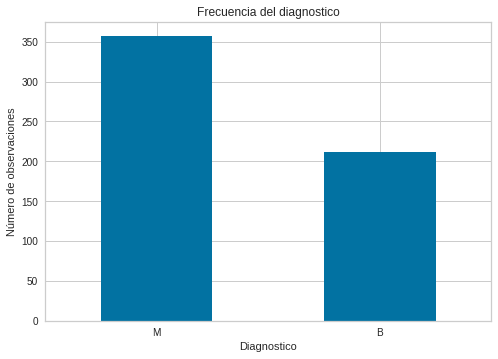

In [ ]:
count_classes = pd.value_counts(breast_cancer.diagnosis, sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(2), ['M', 'B'])
plt.title('Frecuencia del diagnostico')
plt.xlabel('Diagnostico')
plt.ylabel('Número de observaciones')
plt.show()

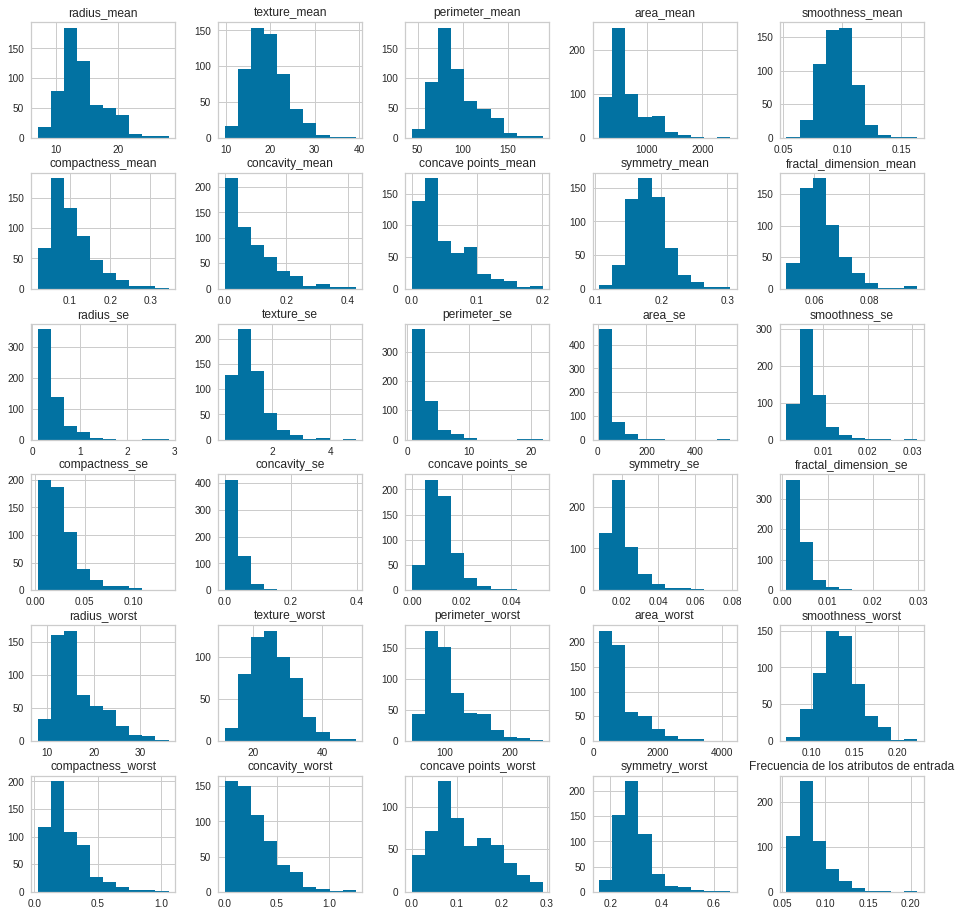

In [ ]:
breast_cancer.drop('diagnosis', axis=1).hist(figsize=(16, 16))
plt.title('Frecuencia de los atributos de entrada')
plt.show()

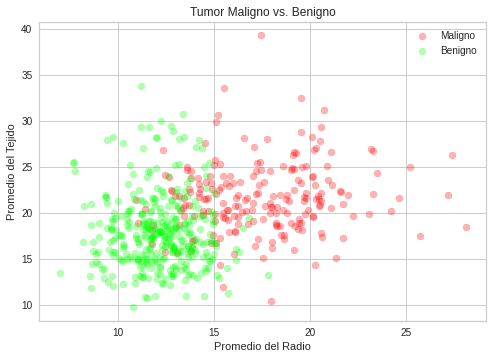

In [ ]:
M = breast_cancer[breast_cancer.diagnosis == 'M']
B = breast_cancer[breast_cancer.diagnosis == 'B']

plt.title('Tumor Maligno vs. Benigno')
plt.xlabel('Promedio del Radio')
plt.ylabel('Promedio del Tejido')
plt.scatter(M.radius_mean, M.texture_mean, color = "red", label = 'Maligno', alpha = 0.3)
plt.scatter(B.radius_mean, B.texture_mean, color = "lime", label = 'Benigno', alpha = 0.3)
plt.legend()
plt.show()

In [ ]:
breast_cancer = pd.get_dummies(
    breast_cancer, columns=['diagnosis'], drop_first=True
)
breast_cancer.rename(
    columns={'diagnosis_M': 'diagnosis'}, inplace=True
)

breast_cancer.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis'],
      dtype='object')

In [ ]:
X = breast_cancer.drop('diagnosis', axis=1)
y = breast_cancer.diagnosis

X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: uint8

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=00000
)

In [ ]:
def naive_bayes_model(X_train, X_test, y_train, y_test):
    '''Aplicación del modelo de Naive Bayes, entrenamiento y predicción.'''

    # Creación del modelo de Naive Bayes
    clf = GaussianNB()

    # Entrenamiento del modelo
    clf.fit(X_train, y_train)

    # Cálculos de las predicciones en Train y Test
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    return clf, y_train_pred, y_test_pred

In [ ]:
model, y_train_pred, y_test_pred = naive_bayes_model(
    X_train, X_test, y_train, y_test
)

In [ ]:
def naive_bayes_confusion_matrix(
    model, X_train, X_test, y_train, y_test
):
    matrix = ConfusionMatrix(model)
    matrix.fit(X_train, y_train)
    matrix.score(X_test, y_test)
    matrix.show()


def naive_bayes_metrics(
    y_train, y_test, y_train_pred, y_test_pred
):
    # Cálculo el accuracy en Train
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Cálculo el accuracy en Test
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f'El accuracy en train es: {train_accuracy}')
    print(f'El accuracy en test es: {test_accuracy}\n\n')

    print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


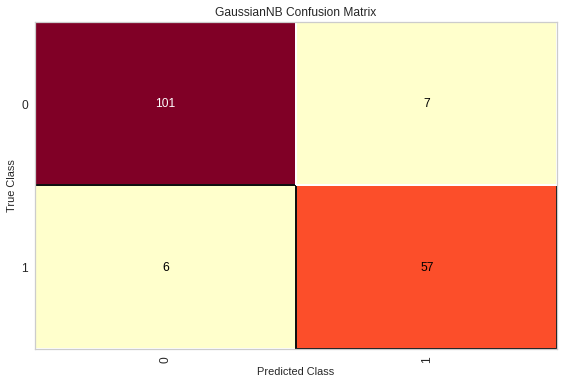

In [ ]:
naive_bayes_confusion_matrix(model, X_train, X_test, y_train, y_test)

In [ ]:
naive_bayes_metrics(y_train, y_test, y_train_pred, y_test_pred)

El accuracy en train es: 0.9422110552763819
El accuracy en test es: 0.9239766081871345


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       108
           1       0.89      0.90      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171



In [ ]:
train = X_train.copy()
train['diagnosis'] = y_train

In [ ]:
def get_edges(train):
  est = HillClimbSearch(train)
  return est.estimate(max_indegree=1).edges()

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
for i in best_model:
  print(i)

('radius_mean', 'area_mean')
('area_mean', 'compactness_se')
('symmetry_mean', 'radius_worst')
('smoothness_se', 'radius_se')
('smoothness_se', 'fractal_dimension_se')
('smoothness_se', 'compactness_mean')
('smoothness_se', 'fractal_dimension_worst')
('smoothness_se', 'area_se')
('smoothness_se', 'perimeter_se')
('smoothness_se', 'compactness_worst')
('smoothness_se', 'perimeter_mean')
('smoothness_se', 'texture_se')
('smoothness_se', 'texture_worst')
('smoothness_se', 'symmetry_worst')
('smoothness_se', 'fractal_dimension_mean')
('smoothness_se', 'symmetry_se')
('smoothness_se', 'texture_mean')
('smoothness_se', 'concave points_worst')
('smoothness_se', 'smoothness_mean')
('compactness_se', 'smoothness_se')
('concavity_se', 'concavity_worst')
('concave points_se', 'concavity_se')
('radius_worst', 'area_worst')
('area_worst', 'radius_mean')
('smoothness_worst', 'symmetry_mean')
('concavity_worst', 'concavity_mean')
('concavity_worst', 'concave points_mean')
('concavity_worst', 'perimet

In [ ]:
def bayesian_model(best_model, train):
  bn = BayesianNetwork(best_model)
  bn.fit(train, estimator=BayesianEstimator, prior_type='BDeu')
  return bn

bn = bayesian_model(get_edges(train), train)

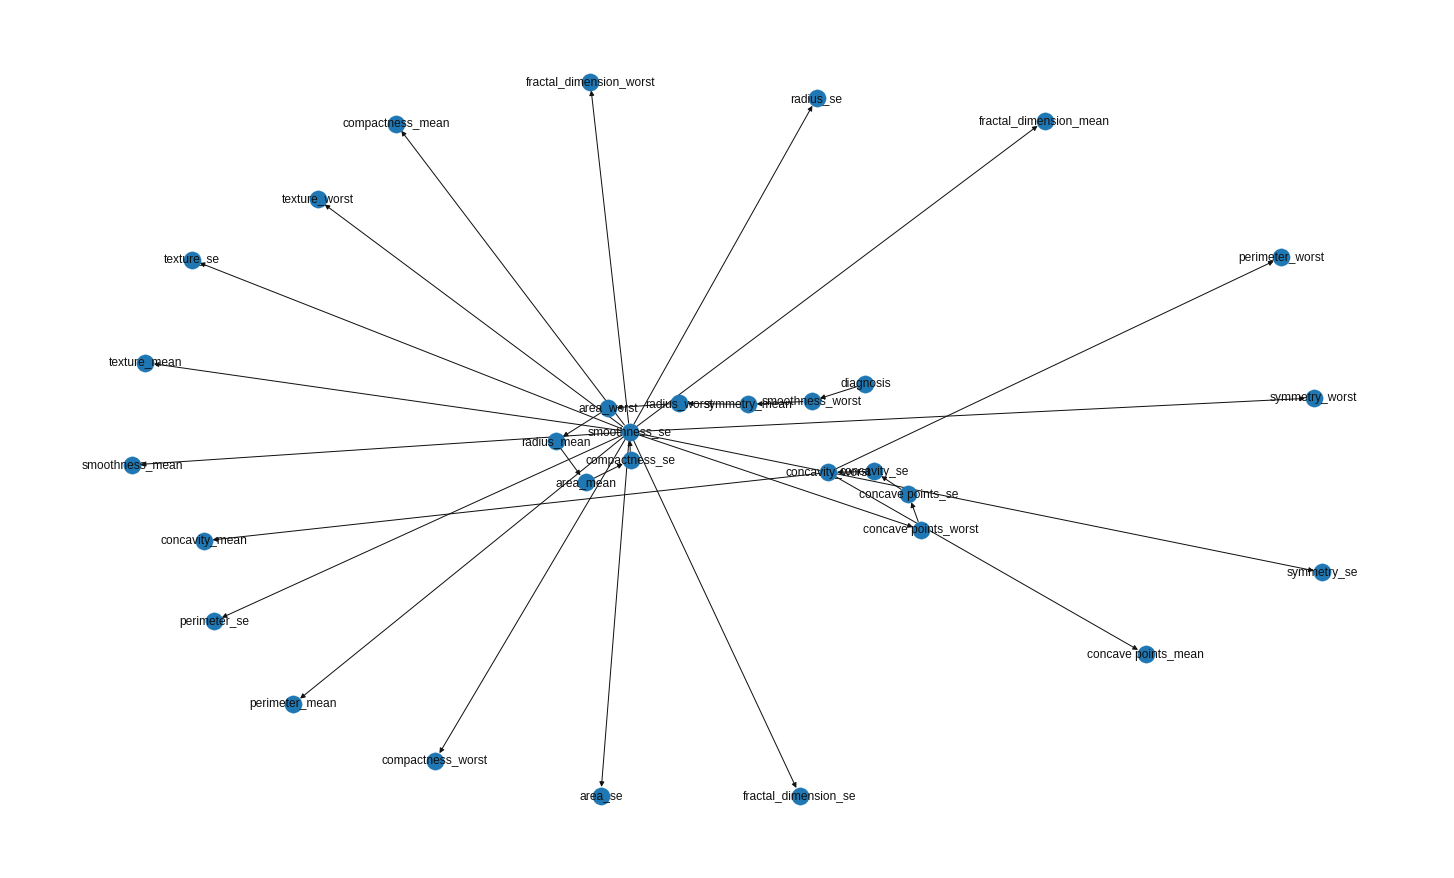

In [ ]:
def plot_bayesian(bn):
  plt.figure(figsize=(20, 12))
  nx_graph = nx.DiGraph(bn.edges())
  nx.draw(nx_graph, with_labels=True)
  plt.show()

In [ ]:
def createsEvidence(df_point, X_test):
    evidence = {}
    for col in X_test.columns:
      evidence[col] = df_point[col]
    
    return evidence

In [ ]:
predictions = {}

for pred_idx in range(len(X_test)):
  infer = VariableElimination(bn)
  evidence = createsEvidence(X_test.iloc[pred_idx], X_test)
  result = infer.query(['diagnosis'], evidence=evidence)
  predictions[pred_idx] = (result.values[1], y_test.iloc[pred_idx])

KeyError: ignored